# Draw plots of aerosol emissions data
This is used to construct the actual plots used in the Geoscientific Model Developments paper, and other exploratory plots that might be of interest. 

In [1]:
import cartopy.crs as ccrs
import netCDF4 as nc
import pandas as pd
from math import floor
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np


Bad key "text.kerning_factor" on line 4 in
C:\Users\rlamboll\AppData\Local\Continuum\anaconda3\envs\netcdf-5\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
output_folder = "../output/aerosols/"
save_folder = "../output/plots/"
base_str = "baseline"
scenarios = ["TwoYearBlip", "StrongGreen", "ModerateGreen", "FossilFuel"]
variable_names = {
    "CO": "CO_em_anthro", "NH3": "NH3_em_anthro", "NMVOC": "NMVOC_em_anthro",
    "OC": "OC_em_anthro", "SO2": "SO2_em_anthro", "NOx": "NOx_em_anthro", "BC": "BC_em_anthro"
}
base_file = "cut_{}-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.ncv4.nc_{}.nc"
save_str = "emission_map_v1.png"
global_save = "global_emission_v1.png"

In [3]:
selected_time = 12 * 2 + 4 # This is the 5th month in the 2nd year

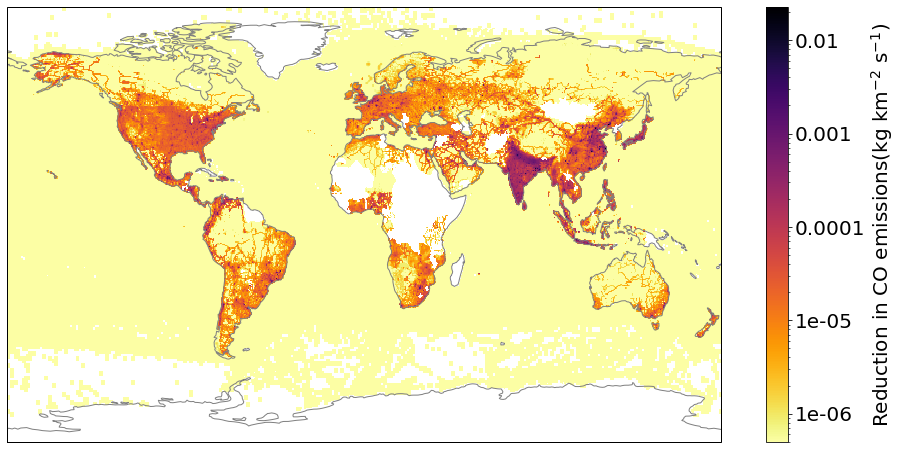

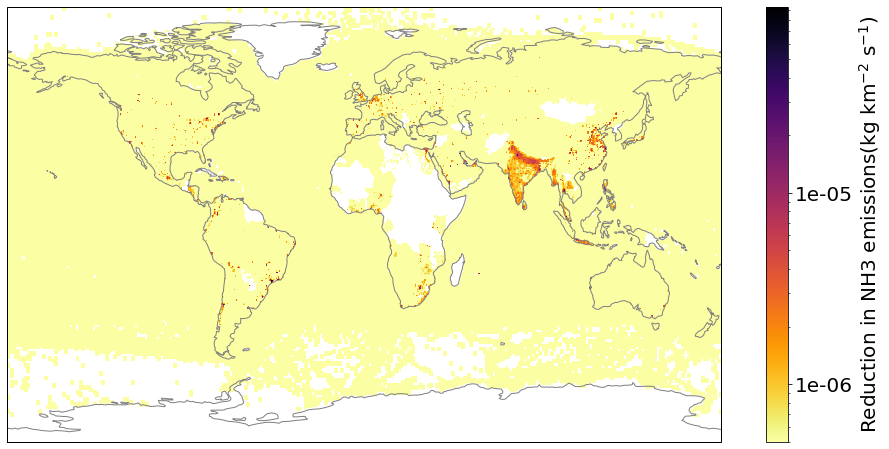

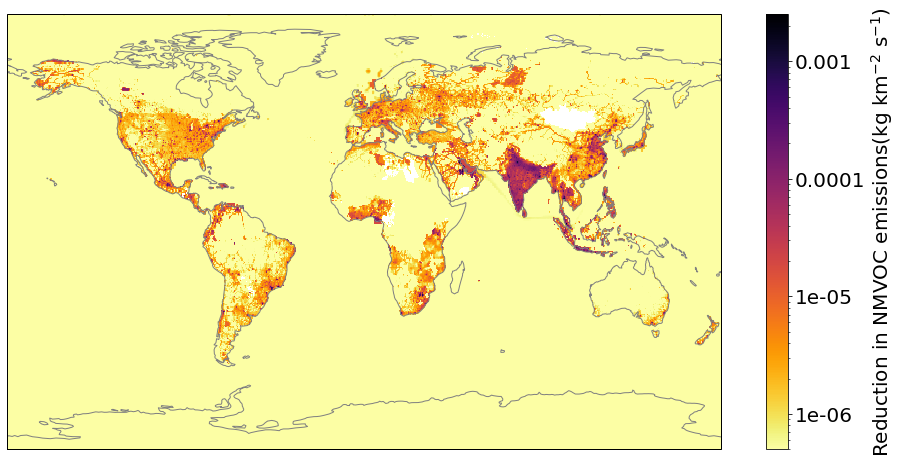

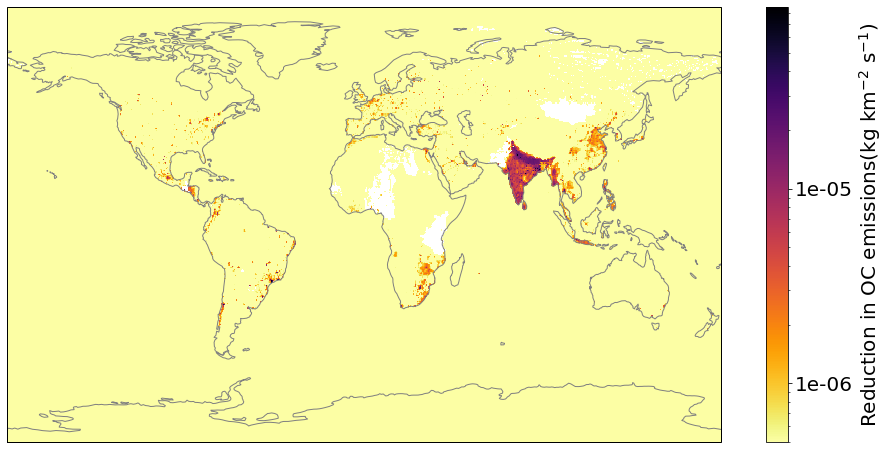

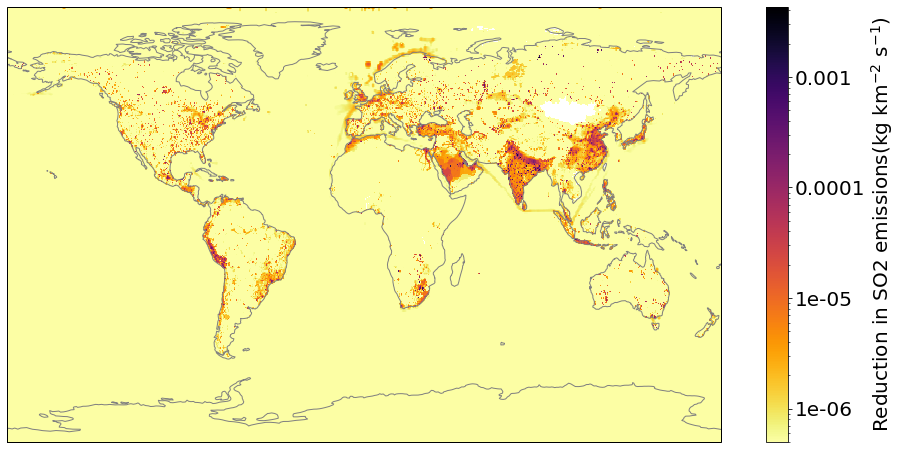

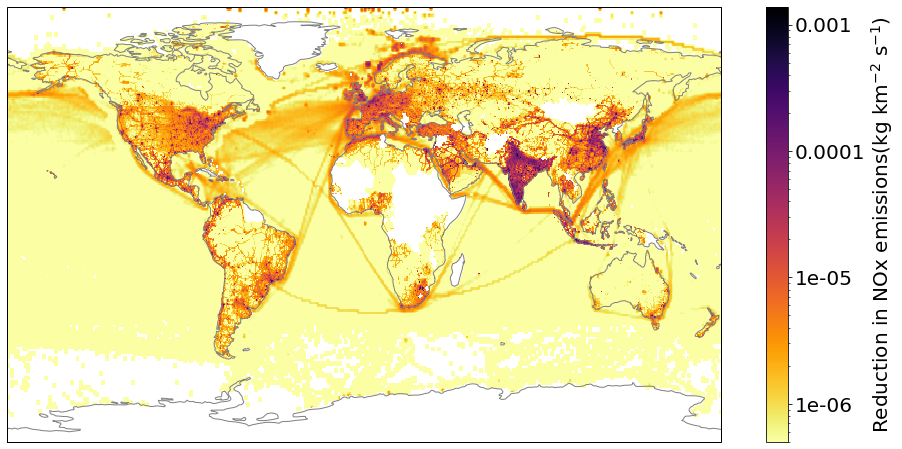

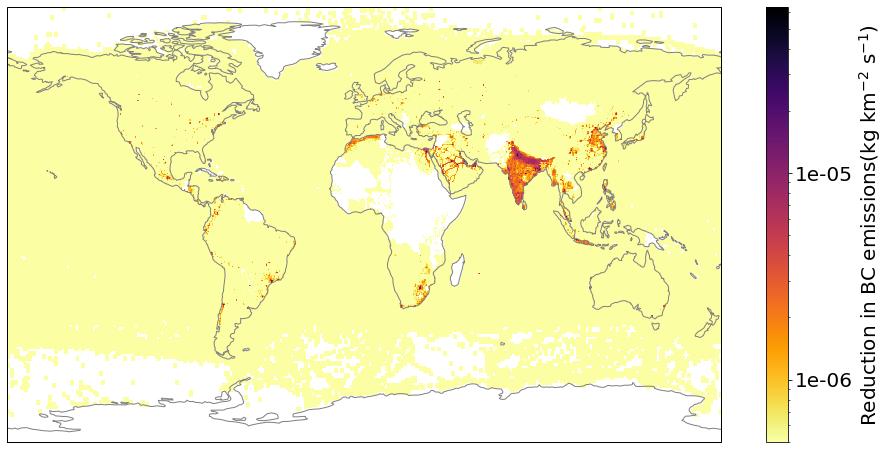

In [4]:
cmap = matplotlib.cm.get_cmap("inferno_r")  # "gist_earth"
matplotlib.rc("font", **{"size": 20})
cmap.set_bad("white", 1.0)
for aerosol, varname in variable_names.items():
    base_em = nc.Dataset(output_folder + base_file.format(aerosol, base_str))
    lats = base_em.variables["lat"][:]
    lons = base_em.variables["lon"][:]
    img_extent = [min(lons), max(lons), min(lats), max(lats)]
    for scenario in scenarios[:1]:
        emission = nc.Dataset(output_folder + base_file.format(aerosol, scenario))
        fig = plt.figure(figsize=(16, 8))
        ax = plt.axes(projection=ccrs.PlateCarree())
        diff_plot = 10 ** 6 * (
                sum(base_em.variables[varname][selected_time, :, :, :]) -
                sum(emission.variables[varname][selected_time, :, :, :])  
            )
        image = ax.imshow(
            diff_plot, norm=LogNorm(vmin=max(abs(diff_plot).min(), 5e-7), 
            vmax=diff_plot.max()), cmap=cmap, aspect='auto', extent= img_extent,
        )
        ax.coastlines(color="grey")
        plt.title("")
        cb = fig.colorbar(image, ax=ax, format="%g")
        cb.ax.set_ylabel("Reduction in {} emissions".format(varname.replace("_em_anthro", "")) +  "(kg km$^{-2}$ s$^{-1}$)")
    fig.savefig(save_folder + varname + save_str, bbox_inches='tight')
    

In [5]:
earth_rad = 6370 * 1e3 # radius of earth in m
area = earth_rad ** 2 * (lons[1] - lons[0]) * (lats[1] - lats[0]) * abs(np.cos(lats[:] * np.pi / 180)) * (np.pi / 180) ** 2

In [6]:
assert np.isclose(sum(area) * len(lons),  5.1 * 10 ** 14, rtol=0.1)  # Check this is the correct area of the earth in m^2! 

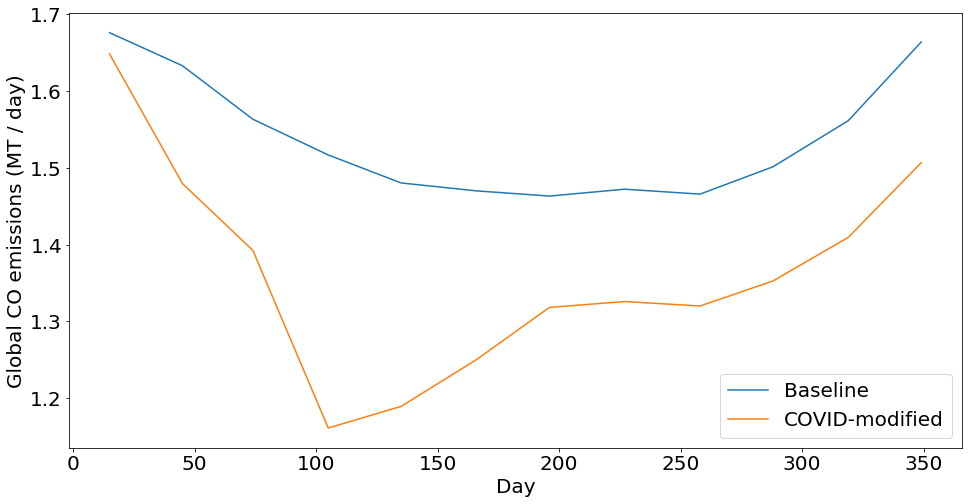

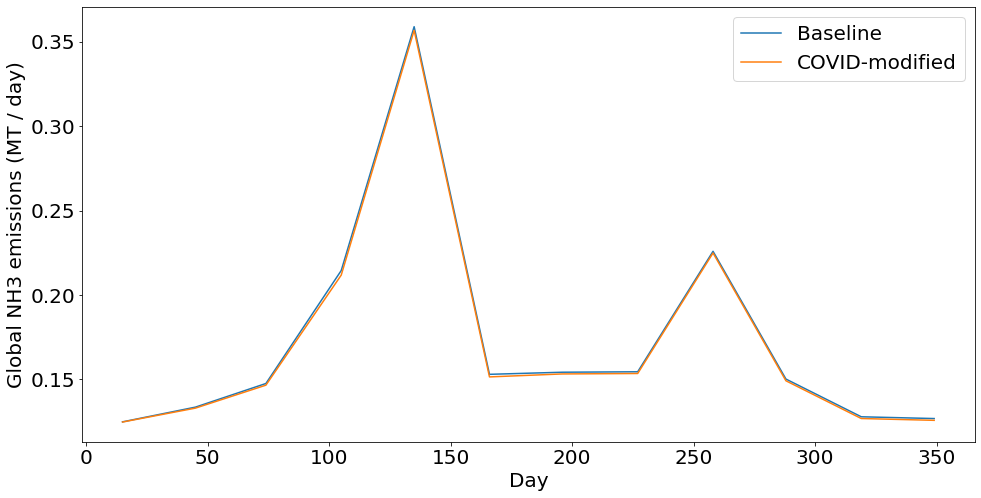

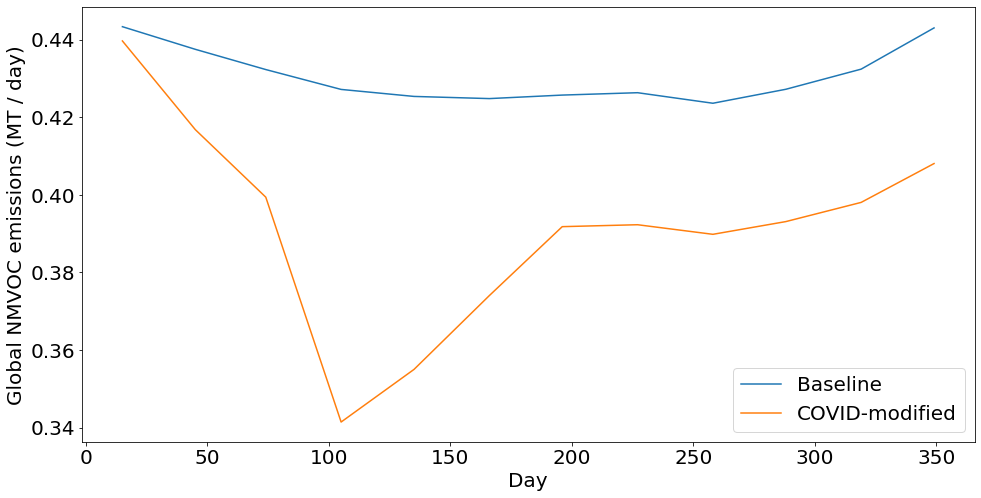

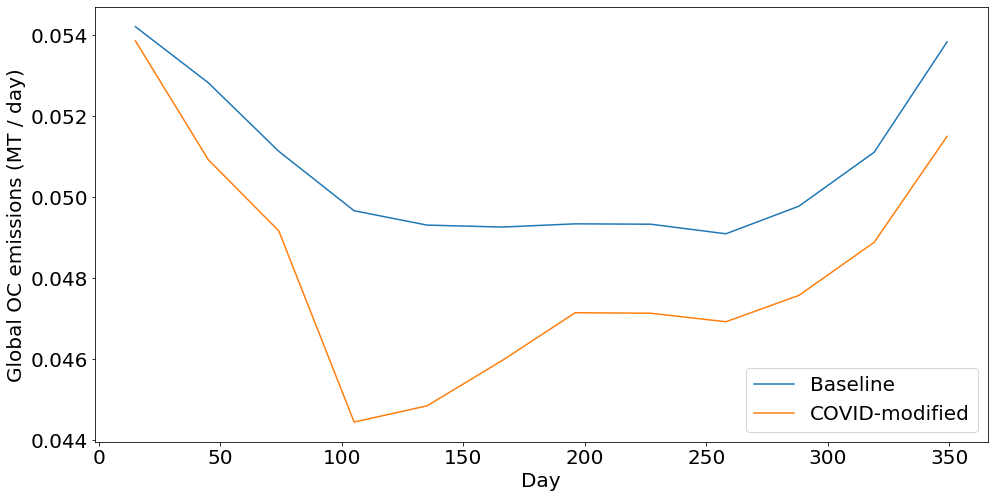

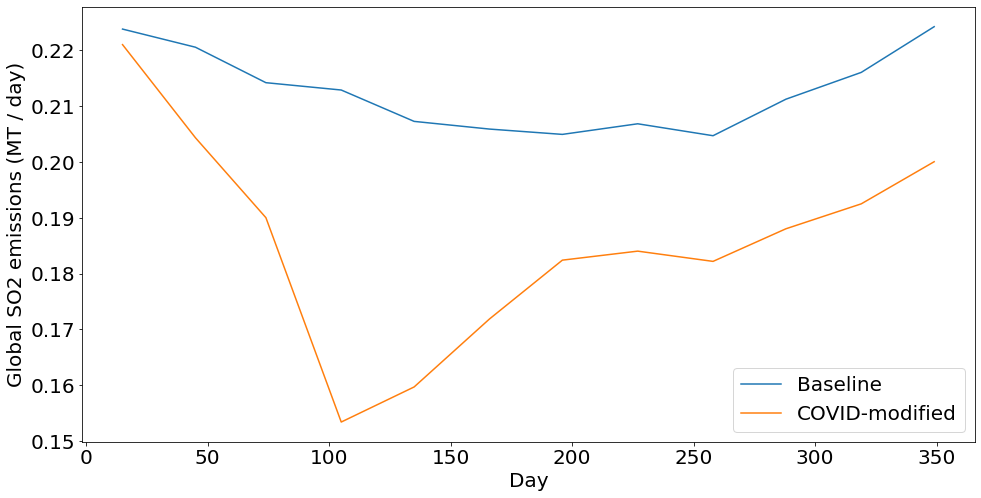

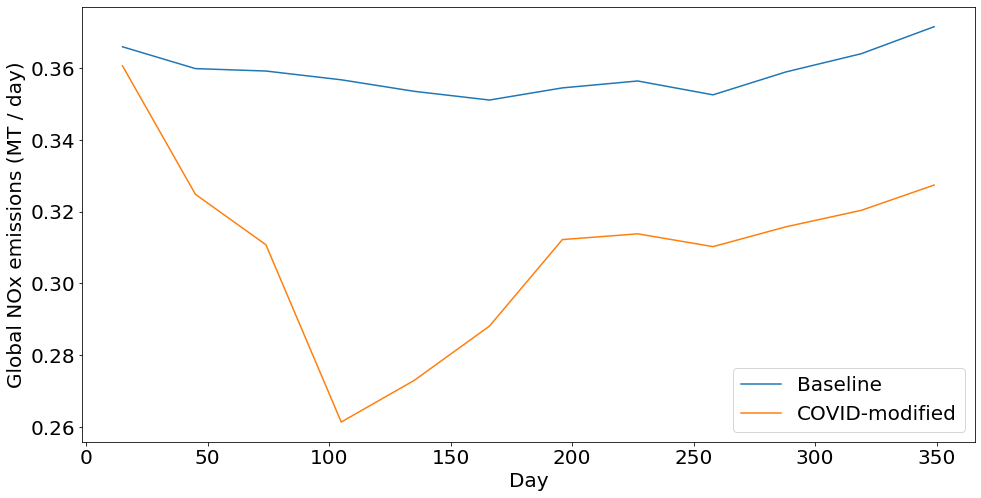

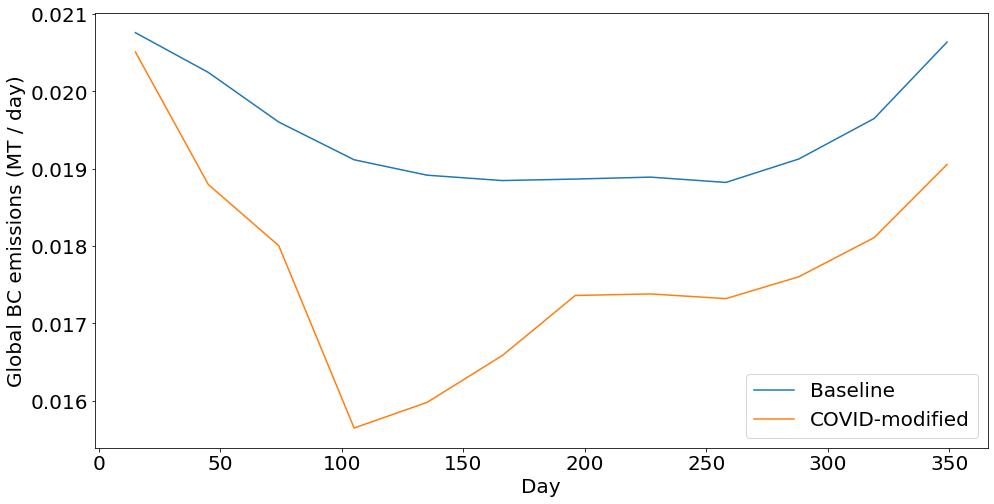

In [7]:
plot_times = range(12 * 2, 12 * 3)
kg_per_sec = 3600 * 24 / 10 ** 9 # convert kg/sec to MT/day
for aerosol, varname in variable_names.items():
    base_em = nc.Dataset(output_folder + base_file.format(aerosol, base_str))
    world_base_emissions = base_em.variables[varname][:, :, :, :].sum(1).sum(2).dot(area)
    fig = plt.figure(figsize=(16, 8))
    plt.plot(base_em.variables["time"][plot_times] - 5 * 365, world_base_emissions[plot_times] * kg_per_sec)
    for scenario in scenarios[:1]:
        emission = nc.Dataset(output_folder + base_file.format(aerosol, scenario))
        world_emissions = emission.variables[varname][:, :, :, :].sum(1).sum(2).dot(area)
        plt.plot(emission.variables["time"][plot_times] - 5 * 365, world_emissions[plot_times] * kg_per_sec)
        plt.xlabel("Day")
        plt.ylabel("Global {} emissions (MT / day)".format(varname.replace("_em_anthro", "")))
        plt.legend(["Baseline", "COVID-modified"])
    fig.savefig(save_folder + varname + global_save)

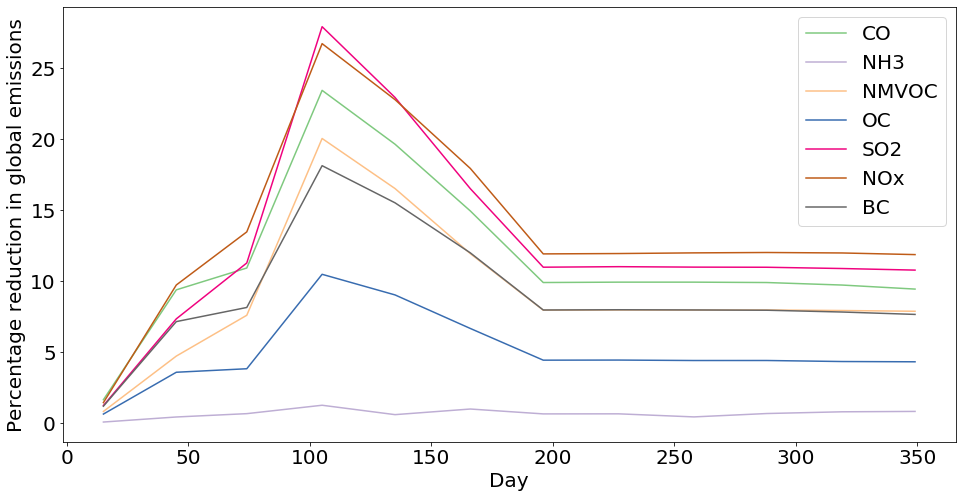

In [35]:
plot_times = range(12 * 2, 12 * 3)
leg_str = []
int = 0
colorlist = plt.cm.Accent(np.linspace(0,1,len(variable_names.keys())))
fig = plt.figure(figsize=(16, 8))
for aerosol, varname in variable_names.items():
    base_em = nc.Dataset(output_folder + base_file.format(aerosol, base_str))
    world_base_emissions = base_em.variables[varname][:, :, :, :].sum(1).sum(2).dot(area)
    for scenario in scenarios[:1]:
        emission = nc.Dataset(output_folder + base_file.format(aerosol, scenario))
        world_emissions = emission.variables[varname][:, :, :, :].sum(1).sum(2).dot(area)
        plt.plot(
            emission.variables["time"][plot_times] - 5 * 365, 
            100 * (1 - world_emissions[plot_times] / world_base_emissions[plot_times]), 
            color=colorlist[int]
        )
        int += 1
        plt.xlabel("Day")
        plt.ylabel("Percentage reduction in global emissions")
    leg_str.append(aerosol)
plt.legend(leg_str)
fig.savefig(save_folder + "all_relative_data" + global_save)

In [31]:
colorlist = plt.cm.Accent(np.linspace(0,1,len(variable_names.keys())))
#plt.cm.get_cmap("hsv", np.linspace(0, 1, len(variable_names.keys())))

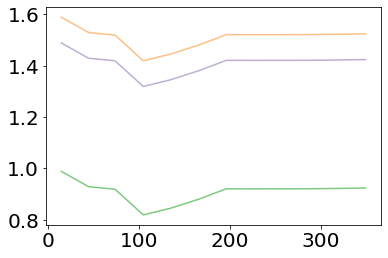

In [32]:
plt.plot(
            emission.variables["time"][plot_times] - 5 * 365, 
            world_emissions[plot_times] / world_base_emissions[plot_times], 
            color=colorlist[0]
        )
plt.plot(
            emission.variables["time"][plot_times] - 5 * 365, 
            world_emissions[plot_times] / world_base_emissions[plot_times] + 0.5, 
            color=colorlist[1]
        )
plt.plot(
            emission.variables["time"][plot_times] - 5 * 365, 
            world_emissions[plot_times] / world_base_emissions[plot_times] + 0.6, 
            color=colorlist[2]
        )